<a href="https://colab.research.google.com/github/Steve-YJ/deep-learning-from-scratch-studying/blob/master/VAE_Tutorial_01_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE Tutorial
* Reference: https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/Variational_AutoEncoder.ipynb
* Goal - Implement it and understand it

### 🔖 Review

* 2nd. After learning theory, Review it.
* <a href = 'deepinsight.tistory.com/121'>Lecture Note</a>

In [1]:
# import library
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm  # what is tqdm??
                       # tqdm: tqdm은 즉석에서 progress bar를 생성해주고,
                       # 함수나 반복문의 TTC(Time To Completion)을 예측하는 파이썬 패키지를 말한다.
from torchvision.utils import save_image

In [13]:
torch.cuda.is_available()

True

In [14]:
torch.cuda.get_device_name()

'Tesla K80'

In [4]:
torch.cuda.get_device_capability()  ## get the cuda capability of device

(3, 7)

In [5]:
# Model Hyperparameters
# Set Hyperparameters

dataset_path = '~/datasets'

cuda = True
device = torch.device("cuda" if cuda else "cpu")
# another method: torch.device('cuda')
# cuda = torch.device('cuda)

batch_size = 50 

x_dim = 784
hidden_dim = 400  # 은닉항의 노드는 400
latent_dim = 20   # latent vector의 차원은 20차원

lr = 1e-3
epochs = 10

## Step1. Load(or download) Dataset

In [7]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
        transforms.ToTensor()
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs) 
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, **kwargs) 

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw


Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [8]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

## Step 2. Define our model: Variational AutoEncoder(VAE)

In [15]:
'''
    A simple implementation of Gaussian MLP Encoder and Decoder

'''
## 간단한 Gaussian MLP(Multi Layer Perceptron) Encoder & Decoder !!

class Encoder(nn.Module):
    ## input -> hidden -> latent
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear(hidden_dim, latent_dim)
        self.training=True

    def forward(self, x):
        h_ = torch.relu(self.FC_input(x))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)   # encoder produces mean and log_var
                                    # e.g_ parameters of simple tractable normal distribution "g"
        var = torch.exp(0.5 * log_var)
        z = self.reparameterization(mean, var)
        
        return z, mean, log_var

    def reparameterization(self, mean, var,):
        epsilon = torch.rand_like(var).to(device)        # sampling epsilon
        
        z = mean + var*epsilon                          # reparameterization trick
        
        return z

In [16]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = torch.relu(self.FC_hidden(x))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [17]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def forward(self, x):
        z, mean, log_var = self.Encoder(x)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [18]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

## Step 3. Define Loss function (reprod, loss) and optimizer

In [20]:
# Define Loss Function and Optimizer

from torch.optim import Adam
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr = lr)

## Step 4. Train Variational AutoEncoder(VAE)

In [21]:
# train AE
print("Start training VAE...")

model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  121.67967263572508
	Epoch 2 complete! 	Average Loss:  95.62829336132975
	Epoch 3 complete! 	Average Loss:  91.84380072993771
	Epoch 4 complete! 	Average Loss:  89.8773356744227
	Epoch 5 complete! 	Average Loss:  88.69825079656223
	Epoch 6 complete! 	Average Loss:  87.8496799253284
	Epoch 7 complete! 	Average Loss:  87.2937277687461
	Epoch 8 complete! 	Average Loss:  86.83682787821232
	Epoch 9 complete! 	Average Loss:  86.44482322101099
	Epoch 10 complete! 	Average Loss:  86.1606694380734
Finish!!


## Step 5. Evaluate the model

In [22]:
import matplotlib.pyplot as plt

In [23]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        x_hat, _, _ = model(x)

        break

  0%|          | 0/200 [00:00<?, ?it/s]


In [24]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

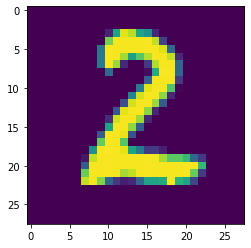

In [25]:
show_image(x, idx=2)

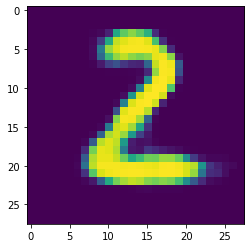

In [26]:
show_image(x_hat, idx=2)

## Step 6. Generate image from noise vector

In [27]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(device)
    generated_images = decoder(noise)


In [28]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

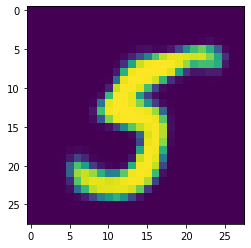

In [29]:
show_image(generated_images, idx=1)

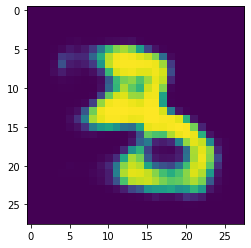

In [ ]:
show_image(generated_images, idx=2)